In [ ]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict , Literal
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from pydantic import BaseModel , Field  



In [ ]:
load_dotenv()
model = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
)

In [ ]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description='Sentiment of the review')

In [ ]:
structured_model = model.with_structured_output(SentimentSchema)

In [ ]:
class ReviewState(TypedDict):
    review: str
    sentiment : Literal["positive", "negative"] = Field(description="Sentiment of the review")
    response: str

In [ ]:
def find_feedback(State: dict):
    prompt = f"Based on the review: {State['review']}, determine the sentiment (positive or negative). Provide only the sentiment."
    response = structured_model.invoke(prompt)
    sentiment = response.sentiment
    return {"sentiment": sentiment}

def positive_response(State: dict):
    prompt = f"Based on the review: {State['review']}, provide a friendly and appreciative response."
    response = model.invoke(prompt)
    return {"response": response}

def negative_response(State: dict):
    prompt = f"Based on the review: {State['review']}, provide an apologetic response offering a solution."
    response = model.invoke(prompt)
    return {"response": response}

def check_sentiment(State: dict) -> Literal["positive_response", "negative_response"]:
    if State['sentiment'] == "positive":
        return "positive_response"
    else:
        return "negative_response"


In [ ]:
graph = StateGraph(ReviewState)
graph.add_node("find_feedback", find_feedback)
graph.add_node("positive_response", positive_response)
graph.add_node("negative_response", negative_response)

graph.add_edge(START, "find_feedback")
graph.add_conditional_edges("find_feedback", check_sentiment)
graph.add_edge("positive_response", END)
graph.add_edge("negative_response", END)

workflow = graph.compile()

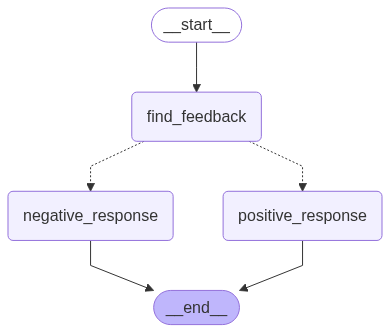

In [ ]:
workflow

In [61]:
intial_state = {
    "review": "I love the new features of this product! It has made my life so much easier.",
}
result = workflow.invoke(intial_state)
result

{'review': 'I love the new features of this product! It has made my life so much easier.',
 'sentiment': 'positive',
 'response': AIMessage(content="That's fantastic to hear! We're so thrilled you're loving the new features and that they're making your life easier.  Thanks for sharing your positive feedback!", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--04ee828e-0846-4863-874b-7f44b83a2df7-0', usage_metadata={'input_tokens': 30, 'output_tokens': 38, 'total_tokens': 68, 'input_token_details': {'cache_read': 0}})}